# Теория вероятностей. Домашнее задание 1

В этом домашнем задании мы построим собственный алгоритм классификации на основе вероятностой модели.

В файле `languages.zip` вы найдете коллекцию текстов на английском, итальянском, испанском, немецком, французском, польском и португальском языках, полученных из случайных статей Википедии. См., например, файл `Spanish.txt`. (В соответствующих файлах `*.sources.txt` указаны источники со ссылками.)

In [9]:
# загружаем данные
import urllib.request
urllib.request.urlretrieve("https://github.com/mariamath/learning_materials/raw/main/data/languages.zip"
                          ,"assets/ex_1/languages.zip")

('assets/ex_1/languages.zip', <http.client.HTTPMessage at 0x1509e3fe360>)

In [10]:
# проверяем загрузку (наличие файла languages.zip)
import os
print(os.listdir("assets/ex_1"))

['languages.zip']


In [11]:
# разархивируем данные
import zipfile
zipfile.ZipFile("assets/ex_1/languages.zip", 'r').extractall("assets/ex_1")

In [12]:
with open("assets/ex_1/Spanish.txt", encoding='utf-8') as f:
    print(f.read(500))

tomas zapata sierra medellin colombia  de mayo de  es productor de cine y de teatrocita requerida
sad eyed lady of the lowlands en espanol senorita de ojos tristes de las tierras bajas es una cancion compuesta por el cantante estadounidense bob dylan fue incluida en el album blonde on blonde editado el  de mayo de 
la revista mojo la coloco en el puesto  de su lista de las  mejores canciones de bob dylan
calyptocephalella canqueli es una especie extinta de anfibio anuro perteneciente al genero c


In [13]:
with open("assets/ex_1/German.txt", encoding='utf-8') as f:
    print(f.read(500))

riedhofe ist der name von ortsteilen in deutschland

in badenwurttemberg
riedhofe langenau ortsteil der stadt langenau im albdonaukreis
riedhofe frickingen ortsteil der gemeinde frickingen im bodenseekreis
riedhofe riegel am kaiserstuhl ortsteil der gemeinde riegel am kaiserstuhl im landkreis emmendingen
riedhofe kongen ortsteil der gemeinde kongen im landkreis esslingen
riedhofe leingarten ortsteil der gemeinde leingarten im landkreis heilbronn
riedhofe bad wurzach ortsteil der stadt bad wurzac


## Визуализация облака слов (0.5 баллов)

Выберите ваш любимый язык из предложенных и визуализируйте самые частые слова из приведенных текстов на этом языке в виде облака слов, используя `WordCloud` из библиотеки `wordcloud`.

In [14]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

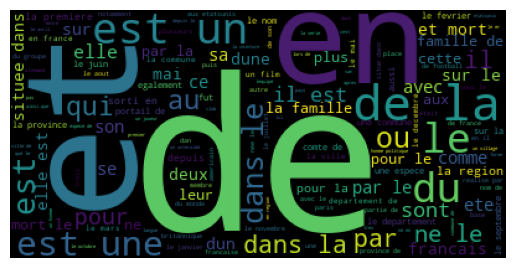

In [15]:
### Решение
with open("assets/ex_1/French.txt", encoding='utf-8') as f:
    text = f.read()


wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()    
